# **Ujian Akhir Semester - Pengolahan Bahasa Alami**

## Anggota Kelompok:
- **Kevin Philips Tanamas** (220711789)  
- **Richard Angelico** (220711747)
- **Anthony Alvin Nathaniel** (220711773)
- **Nicholas Raymond Thosimaru** (220712111)
- **Maria** (220711969)

## Library Import

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import gc
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers import Conv1D

from sklearn.metrics import confusion_matrix
from seqeval.scheme import BILOU
from seqeval.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, TimeDistributed, Dropout
from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.layers import Masking
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

tqdm.pandas()

2025-07-01 05:29:08.985102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 05:29:09.004290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751322549.026660 2937255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751322549.032951 2937255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-01 05:29:09.056016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load Data

In [2]:
def insert_blank_lines(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as infile, open(output_path, 'w', encoding='utf-8') as outfile:
        for line in infile:
            outfile.write(line)
            if line.strip().endswith(('.-O', '!-O', '?-O')):
                outfile.write('\n') 

insert_blank_lines("dataset_betawi.txt", "dataset_betawi_split.txt")

In [3]:
def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label_seq = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                # Baris kosong = akhir kalimat
                if sentence:
                    sentences.append(sentence)
                    labels.append(label_seq)
                    sentence = []
                    label_seq = []
                continue

            # Hapus nomor dan titik dua di depan (contoh: "12: Ane-O")
            if ":" in line:
                line = line.split(":", 1)[1].strip()

            if "-" not in line:
                continue

            token, tag = line.rsplit("-", 1)
            sentence.append(token)
            label_seq.append(tag)

        # Tambahkan kalimat terakhir jika ada
        if sentence:
            sentences.append(sentence)
            labels.append(label_seq)

    return sentences, labels

In [4]:
with open("./dataset_betawi_split.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines[:20]):
    print(f"{i+1}: {line.strip()}")


1: Ane-O
2: pake-O
3: Honda-B-PRODUCT
4: Jazz-I-PRODUCT
5: GK5-I-PRODUCT
6: 2014-L-PRODUCT
7: (-O
8: pertama-O
9: diluncurkan-O
10: )-O
11: .-O
12: 
13: Mobilnya-B-OTHERS_POSITIVE
14: bagus-I-OTHERS_POSITIVE
15: dan-I-OTHERS_POSITIVE
16: bagus-I-OTHERS_POSITIVE
17: sesuai-I-OTHERS_POSITIVE
18: motto-I-OTHERS_POSITIVE
19: ,-I-OTHERS_POSITIVE
20: asik-I-OTHERS_POSITIVE


In [5]:
# Load all data
full_file = "./dataset_betawi_split.txt"
sentences, labels = load_data(full_file)

# Check if data loaded
print(f"Loaded {len(sentences)} samples.")

# Split into train (70%) and temp (30%)
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)

# Split temp into validation (15%) and test (15%)
valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)

# Create dataframes
train_df = pd.DataFrame({'tokens': train_sentences, 'tags': train_labels})
valid_df = pd.DataFrame({'tokens': valid_sentences, 'tags': valid_labels})
test_df = pd.DataFrame({'tokens': test_sentences, 'tags': test_labels})
df_all = pd.DataFrame({'tokens': sentences, 'tags': labels})

# Informasi tentang kolom
print("\nInformasi kolom DataFrame:")
print(df_all.dtypes)

# Deskripsi singkat isi data
lengths = [len(s) for s in sentences]
print("\nDeskripsi data:")
print(f"Total kalimat: {len(sentences)}")
print(f"Rata-rata panjang kalimat: {sum(lengths)/len(lengths):.2f} tokens")
print(f"Kalimat terpendek: {min(lengths)} tokens")
print(f"Kalimat terpanjang: {max(lengths)} tokens")

# Print sizes
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Loaded 867 samples.

Informasi kolom DataFrame:
tokens    object
tags      object
dtype: object

Deskripsi data:
Total kalimat: 867
Rata-rata panjang kalimat: 18.45 tokens
Kalimat terpendek: 1 tokens
Kalimat terpanjang: 124 tokens
Train: 606, Valid: 130, Test: 131


In [6]:
def validate_data(sentences, labels):
    for i, (sent, lbls) in enumerate(zip(sentences, labels)):
        if len(sent) != len(lbls):
            print(f"Mismatch in sentence {i}: {len(sent)} tokens, {len(lbls)} tags")
        for tag in lbls:
            if tag != 'O' and '-' not in tag:
                print(f"Invalid tag in sentence {i}: {tag}")
            if tag != 'O' and not any(prefix in tag for prefix in ['B-', 'I-', 'L-', 'U-']):
                print(f"Non-BILOU tag in sentence {i}: {tag}")

# Validate dataset after loading
print("Validating dataset...")
validate_data(sentences, labels)
print("Validation complete.")

Validating dataset...
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 0: PRODUCT
Non-BILOU tag in sentence 0: PRODUCT
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OTHERS_POSITIVE
Invalid tag in sentence 1: OTHERS_POSITIVE
Non-BILOU tag in sentence 1: OT

## Data Checking (Liat Semua Tags) & Visualization

In [7]:
# Set all tags (flattened) from training labels
all_tags_flat = [tag for seq in train_labels for tag in seq]

print(f"Total tags in training: {len(all_tags_flat)}")

print("Tag distribution in training set:")
tag_counts = pd.Series(all_tags_flat).value_counts()
print(tag_counts.head(10))

Total tags in training: 11221
Tag distribution in training set:
O                   6845
PRODUCT             1093
OTHERS_POSITIVE      697
MACHINE_POSITIVE     471
PART_POSITIVE        441
PART_NEGATIVE        310
FUEL_POSITIVE        306
PRICE_POSITIVE       227
SERVICE_POSITIVE     214
SERVICE_NEGATIVE     193
Name: count, dtype: int64


/tmp/ipykernel_2937255/2071062896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")


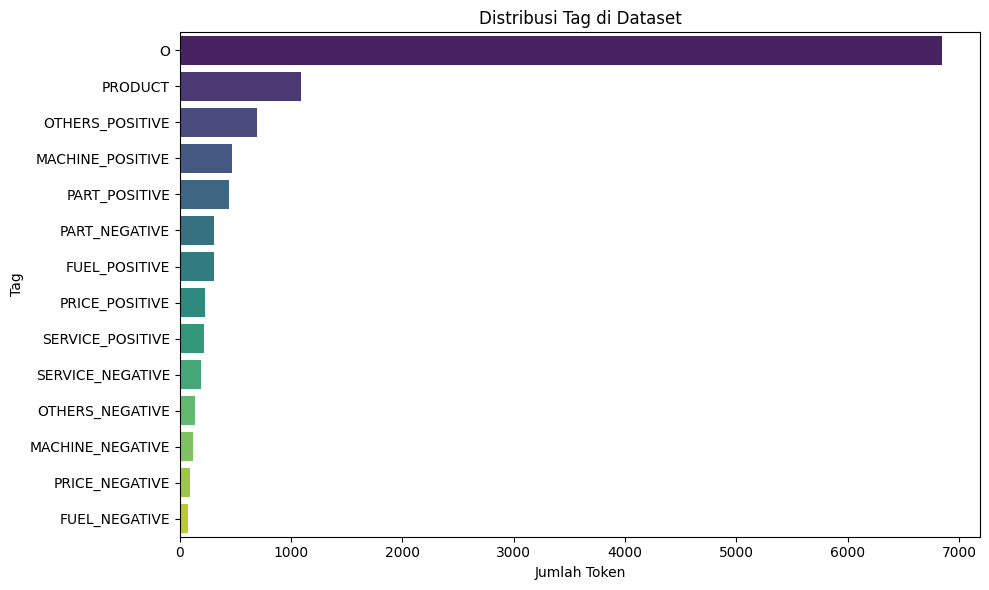

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="viridis")
plt.title("Distribusi Tag di Dataset")
plt.xlabel("Jumlah Token")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

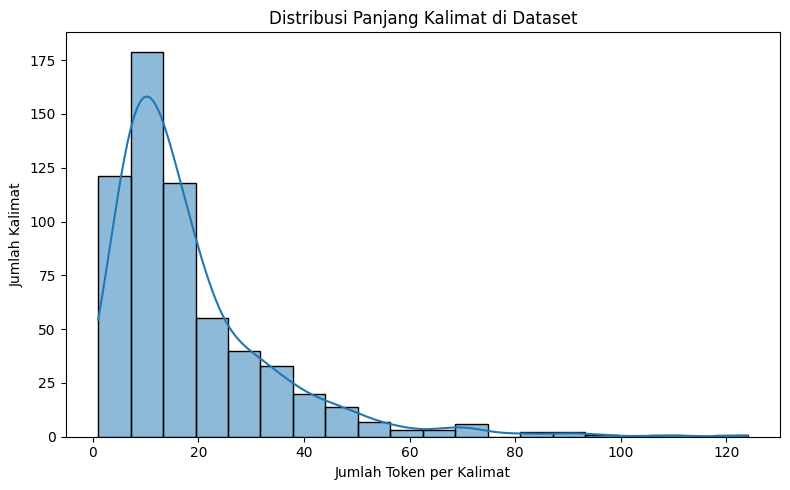

In [9]:
train_lengths = [len(seq) for seq in train_sentences]

plt.figure(figsize=(8, 5))
sns.histplot(train_lengths, bins=20, kde=True)
plt.title("Distribusi Panjang Kalimat di Dataset")
plt.xlabel("Jumlah Token per Kalimat")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2937255/2212785168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")


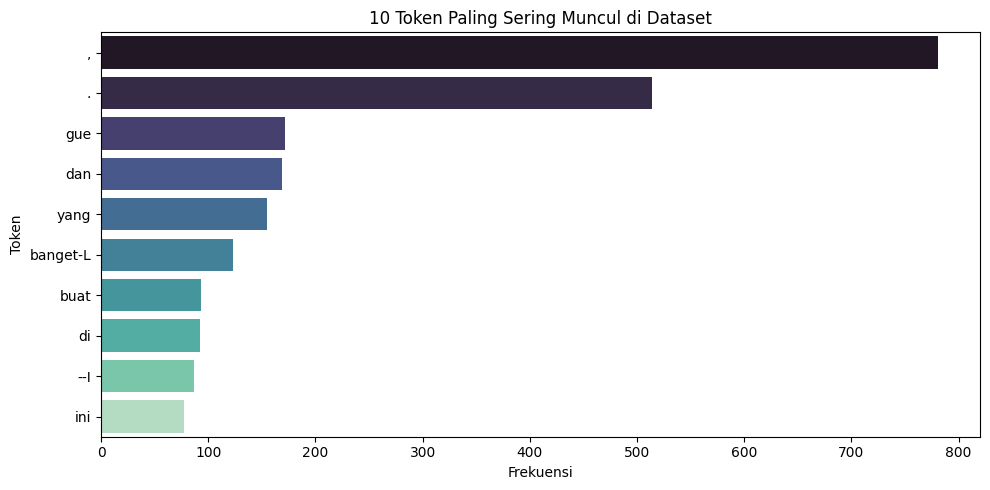

In [10]:
all_tokens = [tok for seq in train_sentences for tok in seq]
token_counts = Counter(all_tokens)
common_tokens = pd.Series(dict(token_counts.most_common(10)))

plt.figure(figsize=(10, 5))
sns.barplot(x=common_tokens.values, y=common_tokens.index, palette="mako")
plt.title("10 Token Paling Sering Muncul di Dataset")
plt.xlabel("Frekuensi")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2937255/1962913272.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")


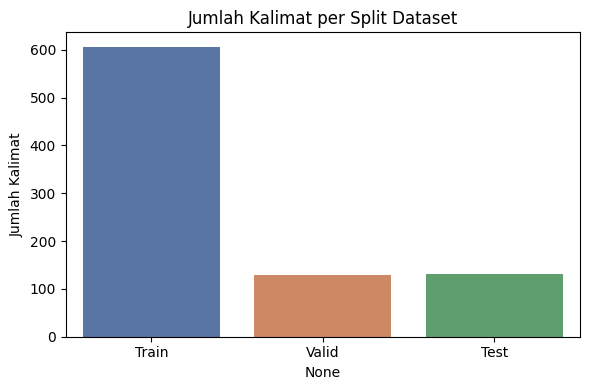

In [11]:
split_counts = pd.Series({
    "Train": len(train_df),
    "Valid": len(valid_df),
    "Test": len(test_df)
})

plt.figure(figsize=(6, 4))
sns.barplot(x=split_counts.index, y=split_counts.values, palette="deep")
plt.title("Jumlah Kalimat per Split Dataset")
plt.ylabel("Jumlah Kalimat")
plt.tight_layout()
plt.show()

## Load FastText Model

In [12]:
# Cek dan unduh FastText model jika belum tersedia
if not os.path.exists('./cc.id.300.bin'):
    print("FastText model not found. Downloading model (this may take a while)...")
    os.system("wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz")
    os.system("gunzip cc.id.300.bin.gz")
    print("Download complete.")

# Load FastText model
# Download file .bin https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
# Extract file .gz
# Pastikan file cc.id.300.bin ada di direktori yang sama dengan Jupyter Notebook ini
print("Loading FastText model...")
ft = fasttext.load_model('./cc.id.300.bin')
print("FastText model loaded successfully.")

# Set embedding size dan panjang maksimum urutan
emb_size = 300
max_seq_len = 128


Loading FastText model...
FastText model loaded successfully.


## Tag Mapping

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Buat mapping tag ke ID
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0
index2tag = {idx: tag for tag, idx in tag2index.items()}

num_tags = len(tag2index)

# Fungsi untuk encoding dan padding label
def encode_tags(tags, tag2index, max_len):
    tag_ids = [tag2index.get(tag, tag2index['PAD']) for tag in tags]
    return pad_sequences([tag_ids], maxlen=max_len, padding='post', value=tag2index['PAD'])[0]

train_df['tag_ids'] = train_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
valid_df['tag_ids'] = valid_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))
test_df['tag_ids'] = test_df['tags'].apply(lambda tags: encode_tags(tags, tag2index, max_seq_len))

print(f"Number of unique tags (including PAD): {num_tags}")

Number of unique tags (including PAD): 15


## Word Embeddings Function

In [14]:
# Membuat fungsi untuk menghasilkan word embeddings dari token
def get_tok_emb(tokens):
    emb = np.zeros((max_seq_len, emb_size))
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb

# Proses pembuatan embeddings untuk setiap token dalam dataset
print("Creating word embeddings...")
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
valid_df['tokens_embedding'] = valid_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

Creating word embeddings...


100%|██████████| 131/131 [00:00<00:00, 5073.96it/s]


In [15]:
# Membuat mapping untuk tag ke indeks dan sebaliknya
print("Creating tag mapping...")

# Ambil semua tag unik dari data latih
all_tags = sorted(set(tag for seq in train_df['tags'] for tag in seq))
print(f"Number of unique tags: {len(all_tags)}")

# Buat mapping dari tag ke indeks, dengan indeks 0 untuk padding
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index['PAD'] = 0  # PAD token at index 0

# Buat mapping sebaliknya dari indeks ke tag
index2tag = {idx: tag for tag, idx in tag2index.items()}


# Tampilkan beberapa mapping untuk verifikasi
print("Tag to index mapping (sample):")
for i, (tag, idx) in enumerate(tag2index.items()):
    if i < 10:  # Tampilkan 10 pertama
        print(f"{tag} -> {idx}")


Creating tag mapping...
Number of unique tags: 14
Tag to index mapping (sample):
FUEL_NEGATIVE -> 1
FUEL_POSITIVE -> 2
MACHINE_NEGATIVE -> 3
MACHINE_POSITIVE -> 4
O -> 5
OTHERS_NEGATIVE -> 6
OTHERS_POSITIVE -> 7
PART_NEGATIVE -> 8
PART_POSITIVE -> 9
PRICE_NEGATIVE -> 10


In [16]:
def get_tag_emb(tags):
    emb = np.zeros((max_seq_len), dtype=int)
    for i, tag in enumerate(tags[:max_seq_len]):
        emb[i] = tag2index.get(tag, 0)  # Gunakan index 0 (PAD) jika tag tidak ditemukan
    return emb

# Terapkan fungsi ke dataset
print("Creating numeric tag embeddings...")

train_df['tags_embedding'] = train_df['tags'].progress_apply(get_tag_emb)
valid_df['tags_embedding'] = valid_df['tags'].progress_apply(get_tag_emb)
test_df['tags_embedding'] = test_df['tags'].progress_apply(get_tag_emb)

Creating numeric tag embeddings...


100%|██████████| 131/131 [00:00<00:00, 100558.90it/s]


## Dimensionality Reduction (PCA)

In [17]:
# Gabungkan semua embedding untuk fit PCA
all_embeddings = np.vstack(train_df['tokens_embedding'].values)
pca_components = 50
pca = PCA(n_components=pca_components)
pca.fit(all_embeddings)

# Transform setiap embedding sequence
def reduce_dims(emb_matrix):
    return pca.transform(emb_matrix)

train_df['tokens_embedding_pca'] = train_df['tokens_embedding'].progress_apply(reduce_dims)
valid_df['tokens_embedding_pca'] = valid_df['tokens_embedding'].progress_apply(reduce_dims)
test_df['tokens_embedding_pca'] = test_df['tokens_embedding'].progress_apply(reduce_dims)

# Update embedding size ke dimensi baru
emb_size = pca_components

100%|██████████| 131/131 [00:00<00:00, 3034.57it/s]


## Optimasi Dataset

In [18]:
X_train = np.stack(train_df['tokens_embedding_pca'].values)
y_train = np.stack(train_df['tag_ids'].values)

X_valid = np.stack(valid_df['tokens_embedding_pca'].values)
y_valid = np.stack(valid_df['tag_ids'].values)

X_test = np.stack(test_df['tokens_embedding_pca'].values)
y_test = np.stack(test_df['tag_ids'].values)

# Expand label dims: (batch_size, timesteps, 1)
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_test = np.expand_dims(y_test, -1)

print("Feature engineering complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

Feature engineering complete.
X_train shape: (606, 128, 50)
y_train shape: (606, 128, 1)
X_valid shape: (130, 128, 50)
X_test shape: (131, 128, 50)


In [19]:
from sklearn.decomposition import IncrementalPCA
import pickle

def reduce_embedding_dimensions(X_train, X_val, X_test, target_dims=70):
    """Reduce embedding dimensions using PCA with minimal memory usage"""

    print(f"Starting PCA dimension reduction to {target_dims} dimensions...")

    # Convert to float32 to save memory
    X_train = np.asarray(X_train, dtype=np.float32)
    X_val = np.asarray(X_val, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)

    # Get original shapes
    train_shape = X_train.shape
    val_shape = X_val.shape
    test_shape = X_test.shape

    # Flatten for PCA
    X_train_flat = X_train.reshape(-1, train_shape[-1])

    # Get non-zero rows (to avoid fitting on padding)
    non_zero_rows = np.any(X_train_flat != 0, axis=1)

    # Fit PCA on a sample of non-zero rows
    ipca = IncrementalPCA(n_components=target_dims, batch_size=1000)
    sample_size = min(100000, np.sum(non_zero_rows))
    sample_indices = np.random.choice(
        np.where(non_zero_rows)[0], size=sample_size, replace=False
    )

    print("Fitting PCA on sample...")
    ipca.fit(X_train_flat[sample_indices])
    print(f"PCA explained variance ratio sum: {sum(ipca.explained_variance_ratio_):.4f}")

    # Transform train set
    print("Transforming train data...")
    X_train_reduced = np.zeros((train_shape[0], train_shape[1], target_dims), dtype=np.float32)
    for i in range(train_shape[0]):
        X_train_reduced[i] = ipca.transform(X_train[i]).reshape(train_shape[1], target_dims)
        if i % 500 == 0:
            print(f"Transformed {i}/{train_shape[0]} train samples")

    # Transform validation set
    print("Transforming validation data...")
    X_val_reduced = np.zeros((val_shape[0], val_shape[1], target_dims), dtype=np.float32)
    for i in range(val_shape[0]):
        X_val_reduced[i] = ipca.transform(X_val[i]).reshape(val_shape[1], target_dims)
        if i % 500 == 0:
            print(f"Transformed {i}/{val_shape[0]} validation samples")

    # Transform test set
    print("Transforming test data...")
    X_test_reduced = np.zeros((test_shape[0], test_shape[1], target_dims), dtype=np.float32)
    for i in range(test_shape[0]):
        X_test_reduced[i] = ipca.transform(X_test[i]).reshape(test_shape[1], target_dims)
        if i % 500 == 0:
            print(f"Transformed {i}/{test_shape[0]} test samples")

    # Cleanup
    del X_train_flat, non_zero_rows
    gc.collect()

    # Save PCA model
    with open('embedding_pca.pkl', 'wb') as f:
        pickle.dump(ipca, f)

    return X_train_reduced, X_val_reduced, X_test_reduced

## Helper Function

In [20]:
def create_optimized_dataset(X, y, batch_size=16, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Bersihkan memori sebelum mulai
gc.collect()

# Siapkan data array dari DataFrame
print("Preparing data arrays...")
X_train = np.asarray(train_df['tokens_embedding'].tolist(), dtype=np.float32)
y_train = np.asarray(train_df['tags_embedding'].tolist(), dtype=np.int32)

X_val = np.asarray(valid_df['tokens_embedding'].tolist(), dtype=np.float32)
y_val = np.asarray(valid_df['tags_embedding'].tolist(), dtype=np.int32)

X_test = np.asarray(test_df['tokens_embedding'].tolist(), dtype=np.float32)
y_test = np.asarray(test_df['tags_embedding'].tolist(), dtype=np.int32)

# Terapkan PCA dengan dimensi embedding baru (misalnya 70)
print("Reducing embedding dimensions...")
target_dims = 70  # Lebih tinggi dari 50 untuk hasil representasi yang lebih baik

X_train_reduced, X_val_reduced, X_test_reduced = reduce_embedding_dimensions(
    X_train, X_val, X_test, target_dims=target_dims
)
reduced_emb_size = target_dims

# Hapus variabel embedding awal untuk hemat memori
del X_train, X_val, X_test
gc.collect()

Preparing data arrays...
Reducing embedding dimensions...
Starting PCA dimension reduction to 70 dimensions...
Fitting PCA on sample...
PCA explained variance ratio sum: 0.9047
Transforming train data...
Transformed 0/606 train samples
Transformed 500/606 train samples
Transforming validation data...
Transformed 0/130 validation samples
Transforming test data...
Transformed 0/131 test samples


0

In [21]:
def masked_accuracy(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    mask = tf.math.not_equal(y_true, 0)
    matches = tf.cast(tf.equal(y_true, tf.cast(y_pred_labels, dtype=y_true.dtype)), dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    matches *= mask
    return tf.reduce_sum(matches) / tf.reduce_sum(mask)

In [22]:
def create_sample_weights(y, pad_token_id):
    return np.where(y != pad_token_id, 1.0, 0.0)

In [23]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, tag2idx['O']), dtype=tf.float32)
    
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss = loss * mask 
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## Model Function

In [64]:
prefixes = ['B', 'I', 'L', 'U']
labels = [
    'FUEL_NEGATIVE', 'FUEL_POSITIVE',
    'MACHINE_NEGATIVE', 'MACHINE_POSITIVE',
    'OTHERS_NEGATIVE', 'OTHERS_POSITIVE',
    'PART_NEGATIVE', 'PART_POSITIVE',
    'PRICE_NEGATIVE', 'PRICE_POSITIVE',
    'SERVICE_NEGATIVE', 'SERVICE_POSITIVE',
    'PRODUCT'
]

tag2idx = {'O': 0}
idx = 1

for label in labels:
    for prefix in prefixes:
        tag = f"{prefix}-{label}"
        tag2idx[tag] = idx
        idx += 1

tag2idx['PAD'] = idx

## Train Model & Visualization Loss and Accuracy

In [65]:
def simple_rnn_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    SimpleRNN model for NER - fastest training, but typically lower accuracy
    
    Args:
    max_len_seq: Maximum sequence length
    emb_size: Embedding size
    rnn_units: Number of RNN units
    num_tags: Number of output tags
    lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')
    
    # Optional projection to reduce dimensions
    x = Dense(128, activation='relu')(inputs)
    
    # SimpleRNN layer - fastest but less capable for sequence modeling
    x = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True)(x)
    
    # Dropout for regularization
    x = Dropout(0.2)(x)
    
    # Output layer with softmax activation for tag prediction
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def bilstm_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional LSTM model for NER - highest accuracy but slowest training
    
    Args:
    max_len_seq: Maximum sequence length
    emb_size: Embedding size
    rnn_units: Number of LSTM units per direction
    num_tags: Number of output tags
    lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')
    
    # Projection layer to reduce dimensions
    x = Dense(128, activation='relu')(inputs)
    
    # Bidirectional LSTM - processes sequences in both directions
    # Higher accuracy for context-dependent tasks like NER
    x = Bidirectional(
        LSTM(rnn_units, return_sequences=True,
             recurrent_dropout=0.0, 
             implementation=2)  # Use implementation=2 for faster but potentially less stable
    )(x)
    
    # Dropout for regularization
    x = Dropout(0.3)(x)
    
    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def bigru_model(max_len_seq, emb_size, rnn_units, num_tags, lr=0.001):
    """
    Bidirectional GRU model - good balance between speed and accuracy
    
    Args:
    max_len_seq: Maximum sequence length
    emb_size: Embedding size
    rnn_units: Number of GRU units per direction
    num_tags: Number of output tags
    lr: Learning rate
    """
    # Input layer
    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')
    
    # Projection layer
    x = Dense(128, activation='relu')(inputs)
    
    # Bidirectional GRU - faster than LSTM with similar capabilities
    x = Bidirectional(
        GRU(rnn_units, return_sequences=True,
            recurrent_dropout=0.0, reset_after=True)  # Modern GRU implementation (faster)
    )(x)
    
    # Dropout for regularization
    x = Dropout(0.2)(x)
    
    # Output layer
    output = TimeDistributed(Dense(num_tags, activation='softmax'))(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [66]:
# Create optimized datasets with slightly larger batch size
batch_size = 16  # Increased from 8 to 16

# Create optimized datasets for training and validation
train_dataset = create_optimized_dataset(X_train_reduced, y_train, batch_size=batch_size)
val_dataset = create_optimized_dataset(X_val_reduced, y_val, batch_size=batch_size)

# Set up callbacks for model training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001
    ),
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect()
    )
]

# Print message indicating the creation of the improved model
print("Creating improved model...")

# Define model options (commented-out code for custom model)
# model = improved_bilou_model(max_seq_len, reduced_emb_size, len(tag2index), lr=0.001)

# Define available models
models = {
    'SimpleRNN': simple_rnn_model(max_seq_len, reduced_emb_size, 64, len(tag2index), lr=0.001),
    'BiLSTM': bilstm_model(max_seq_len, reduced_emb_size, 64, len(tag2index), lr=0.001),
    'BiGRU': bigru_model(max_seq_len, reduced_emb_size, 64, len(tag2index), lr=0.001)
}

# Configuration for training
train_config = {
    'validation_data': val_dataset,
    'epochs': 3,
    'callbacks': callbacks,
    'verbose': 1
}


Creating improved model...


In [67]:
# Select the model type
selected_model = 'BiLSTM'  # Change to 'SimpleRNN', 'BiLSTM', or 'BiGRU'

# Get the selected model
model = models[selected_model]

# Print the model summary
print("Model summary:")
model.summary()


Model summary:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 128, 70)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128, 128)       │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 128, 15)        │         1,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,839 (429.06 KB)

 Trainable params: 109,839 (429.06 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
print("Training model...")
history = model.fit(
     train_dataset,
     validation_data=val_dataset,
     epochs=15,
     callbacks=callbacks,
     verbose=1
)

Training model...
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.8310 - loss: 1.5769 - val_accuracy: 0.8869 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9149 - loss: 0.3569 - val_accuracy: 0.9422 - val_loss: 0.2383 - learning_rate: 0.0010
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9452 - loss: 0.2167 - val_accuracy: 0.9432 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9467 - loss: 0.1852 - val_accuracy: 0.9459 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9499 - loss: 0.1639 - val_accuracy: 0.9497 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9534 - loss: 0.1478 - val_accuracy: 0.9543 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9567 - lo

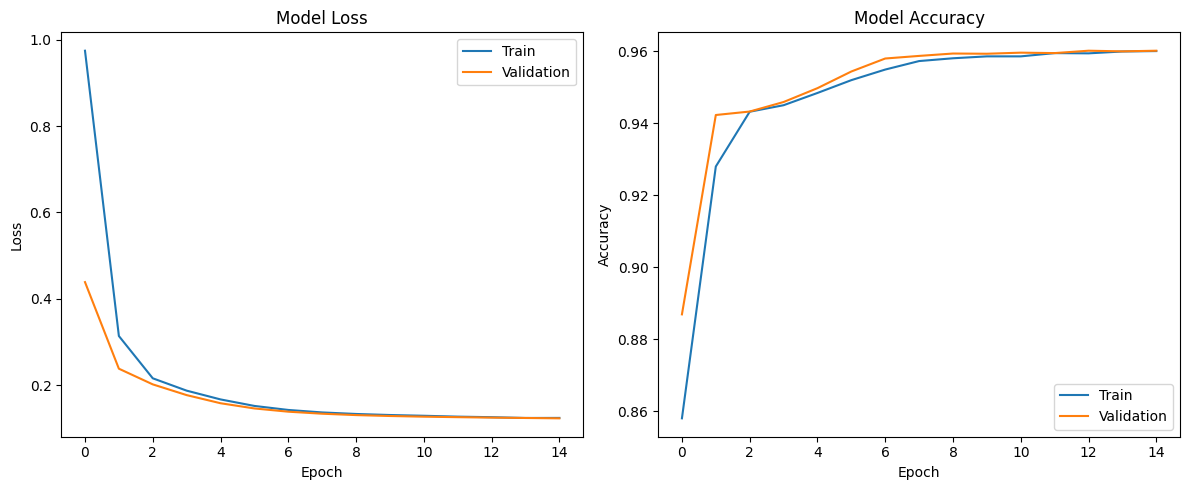

In [69]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()

plt.savefig('training_history.png')
plt.show()


Making predictions on test dataset...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Converting tags to BILOU format...
True tag distribution: Counter({'O': 1332, 'U-PRODUCT': 228, 'U-OTHERS_POSITIVE': 158, 'U-PART_NEGATIVE': 72, 'U-MACHINE_POSITIVE': 69, 'U-SERVICE_POSITIVE': 65, 'U-FUEL_POSITIVE': 54, 'U-PART_POSITIVE': 53, 'U-SERVICE_NEGATIVE': 53, 'U-PRICE_POSITIVE': 51, 'U-OTHERS_NEGATIVE': 30, 'U-MACHINE_NEGATIVE': 29, 'U-PRICE_NEGATIVE': 19, 'U-FUEL_NEGATIVE': 8})
Predicted tag distribution: Counter({'O': 1322, 'U-PRODUCT': 449, 'U-OTHERS_POSITIVE': 319, 'U-PART_POSITIVE': 65, 'U-MACHINE_POSITIVE': 47, 'U-PART_NEGATIVE': 15, 'U-SERVICE_POSITIVE': 4})
Unique entities in y_true_clean: ['FUEL_NEGATIVE', 'FUEL_POSITIVE', 'MACHINE_NEGATIVE', 'MACHINE_POSITIVE', 'OTHERS_NEGATIVE', 'OTHERS_POSITIVE', 'PART_NEGATIVE', 'PART_POSITIVE', 'PRICE_NEGATIVE', 'PRICE_POSITIVE', 'PRODUCT', 'SERVICE_NEGATIVE', 'SERVICE_POSITIVE']
Unique entities in y_pred_clean: ['MACHINE_POSITIVE', 'OTHERS_POSITIVE', 'PA

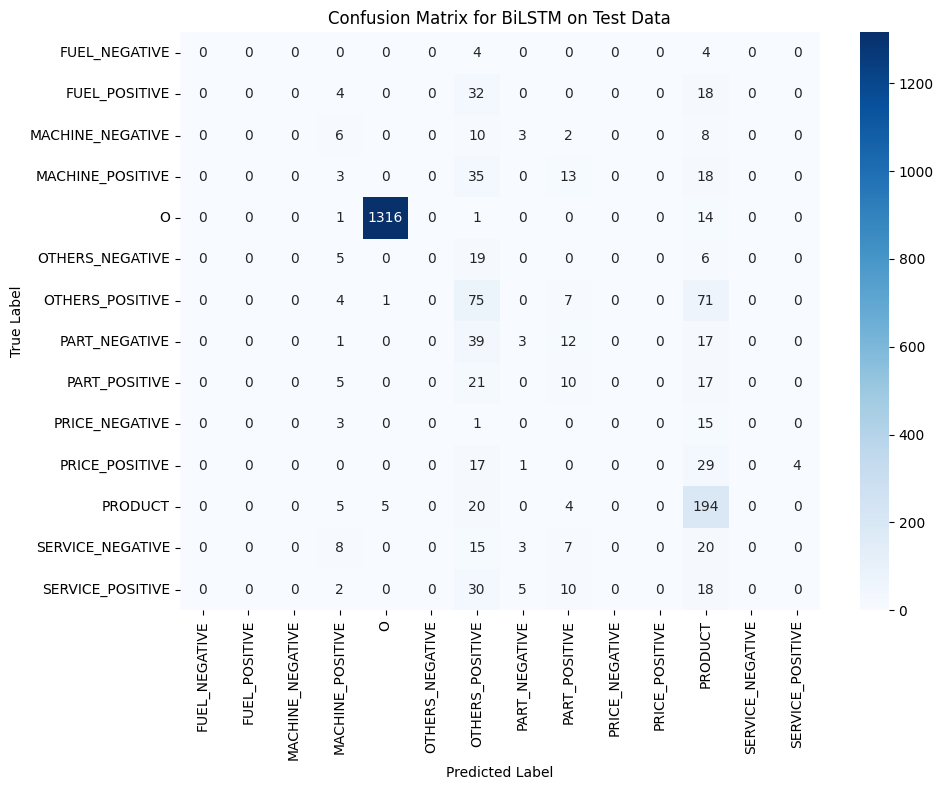

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seqeval.metrics import f1_score, classification_report
from seqeval.scheme import BILOU
from sklearn.metrics import confusion_matrix
from collections import Counter

# Define max_len (consistent with preprocess_text in the test cell)
max_len = 128

# Function to convert non-BILOU tags to BILOU format
def convert_to_bilou(tags):
    bilou_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            bilou_tags.append('O')
        elif '-' not in tag:
            # Treat standalone tags (e.g., PRODUCT) as unit-length entities (U-)
            bilou_tags.append(f'U-{tag}')
        else:
            prefix, entity = tag.split('-', 1)
            if prefix in ['B', 'I', 'L', 'U']:
                bilou_tags.append(tag)  # Already in BILOU format
            else:
                # Convert non-BILOU tags (e.g., PRODUCT, OTHERS_POSITIVE) to BILOU
                # Assume single-token entities are U-, multi-token entities need B-, I-, L-
                if i == 0 or tags[i-1] == 'O' or (tags[i-1] != 'O' and '-' in tags[i-1] and tags[i-1].split('-')[1] != tag):
                    # Start of a new entity
                    if i == len(tags)-1 or tags[i+1] == 'O' or (tags[i+1] != 'O' and '-' in tags[i+1] and tags[i+1].split('-')[1] != tag):
                        bilou_tags.append(f'U-{tag}')  # Unit-length entity
                    else:
                        bilou_tags.append(f'B-{tag}')  # Beginning of multi-token entity
                elif i == len(tags)-1 or tags[i+1] == 'O' or (tags[i+1] != 'O' and '-' in tags[i+1] and tags[i+1].split('-')[1] != tag):
                    bilou_tags.append(f'L-{tag}')  # Last token of entity
                else:
                    bilou_tags.append(f'I-{tag}')  # Inside token of entity
    return bilou_tags

# Function to clean tags to ensure valid BILOU format
def clean_bilou_tags(sequences):
    cleaned_sequences = []
    for seq in sequences:
        cleaned_seq = convert_to_bilou(seq)
        cleaned_sequences.append(cleaned_seq)
    return cleaned_sequences

# Function to convert indices to tags
def convert_to_tags(indices, index_map, seq_lengths=None):
    all_tags = []
    for i, seq in enumerate(indices):
        length = seq_lengths[i] if seq_lengths is not None and i < len(seq_lengths) else len(seq)
        tags = [index_map.get(int(idx), 'O') for idx in seq[:length]]
        all_tags.append(tags)
    return all_tags

# Validate entities
def check_valid_entities(tags_list):
    entities = []
    for seq in tags_list:
        for tag in seq:
            if tag != 'O' and '-' in tag:
                entities.append(tag.split('-')[1])
    return sorted(set(entities))

# Make predictions
print("Making predictions on test dataset...")
test_predictions = model.predict(X_test_reduced)
test_pred_indices = np.argmax(test_predictions, axis=-1)

# Convert to tags
test_seq_lengths = [min(len(seq), max_len) for seq in test_df['tokens']]
y_pred_tags = convert_to_tags(test_pred_indices, index2tag, test_seq_lengths)
y_true_tags = test_df['tags'].tolist()

# Ensure consistent lengths
y_pred_fixed = []
for true_seq, pred_seq in zip(y_true_tags, y_pred_tags):
    if len(pred_seq) < len(true_seq):
        y_pred_fixed.append(pred_seq + ['O'] * (len(true_seq) - len(pred_seq)))
    else:
        y_pred_fixed.append(pred_seq[:len(true_seq)])

# Clean tags to BILOU format
print("Converting tags to BILOU format...")
y_true_clean = clean_bilou_tags(y_true_tags)
y_pred_clean = clean_bilou_tags(y_pred_fixed)

# Debug tag distributions
print("True tag distribution:", Counter([tag for seq in y_true_clean for tag in seq]))
print("Predicted tag distribution:", Counter([tag for seq in y_pred_clean for tag in seq]))
print("Unique entities in y_true_clean:", check_valid_entities(y_true_clean))
print("Unique entities in y_pred_clean:", check_valid_entities(y_pred_clean))

# Evaluate F1 score
print("Calculating F1 score...")
test_f1 = f1_score(y_true_clean, y_pred_clean, mode='strict', scheme=BILOU, zero_division=0)
print(f"\nTest F1 Score: {test_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true_clean, y_pred_clean, mode='strict', scheme=BILOU, zero_division=0))

# Visualize confusion matrix
def get_main_types(tags_list):
    return [[tag.split('-')[1] if '-' in tag else tag for tag in seq] for seq in tags_list]

true_types_flat = [t for seq in get_main_types(y_true_clean) for t in seq]
pred_types_flat = [t for seq in get_main_types(y_pred_clean) for t in seq]

unique_types = sorted(set(true_types_flat))
cm = confusion_matrix(true_types_flat, pred_types_flat, labels=unique_types)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_types, yticklabels=unique_types)
plt.title(f'Confusion Matrix for {selected_model} on Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{selected_model}_test_confusion_matrix.png')
plt.show()

## Test With Sample Data

In [73]:
# Evaluate on test set with proper debugging
print("Evaluating model on test set...")

# Define a function to check model predictions
def debug_predictions(model, X_data, y_true_indices, index2tag, num_samples=5):
    """
    Debug the model predictions by comparing the true labels and predicted labels
    on a few samples.

    Args:
    model: Trained model
    X_data: Input data for prediction
    y_true_indices: True indices of the tags
    index2tag: Dictionary mapping indices to tags
    num_samples: Number of samples to debug (default is 5)
    """
    # Get predictions
    pred_probs = model.predict(X_data[:num_samples])
    pred_indices = np.argmax(pred_probs, axis=-1)
    
    print("\nDEBUGGING PREDICTIONS:")
    
    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        
        # Find actual sequence length (non-zero true labels)
        seq_len = np.sum(y_true_indices[i] > 0) if i < len(y_true_indices) else 0
        if seq_len == 0:
            seq_len = 20  # Default to show first 20 tokens
        
        print(f"Sequence length: {seq_len}")
        print("Predicted indices:", pred_indices[i, :seq_len])
        
        # Convert indices to tags
        true_tags = [index2tag.get(idx, "UNK") for idx in y_true_indices[i, :seq_len]]
        pred_tags = [index2tag.get(idx, "UNK") for idx in pred_indices[i, :seq_len]]
        
        # Print comparison
        print("\nTrue vs Predicted Tags:")
        for j, (true, pred) in enumerate(zip(true_tags, pred_tags)):
            print(f"{j+1:3d}: {true:20s} -> {pred:20s} {'✓' if true == pred else '✗'}")
        
        # Check tag distribution in this prediction
        pred_tag_dist = pd.Series(pred_tags).value_counts()
        print("\nPredicted tag distribution:")
        print(pred_tag_dist)
        
        # Check overall distribution
        all_preds = np.argmax(model.predict(X_data), axis=-1).flatten()
        overall_dist = pd.Series([index2tag.get(idx, "UNK") for idx in all_preds]).value_counts()
        print("\nOverall prediction distribution (top 10):")
        print(overall_dist.head(10))

# Debug a few predictions
debug_predictions(model, X_test_reduced, y_val[:5] if len(y_val) >= 5 else y_val, index2tag)

# Predict on full test set
print("Predicting on full test set...")
predicted_probs = model.predict(X_test_reduced)
predicted_indices = np.argmax(predicted_probs, axis=-1)

# Store predicted tags in the test dataframe
test_df['pred_tags_embedding'] = predicted_indices.tolist()


Evaluating model on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

DEBUGGING PREDICTIONS:

Sample 1:
Sequence length: 34
Predicted indices: [ 5 12  5 12 12  7  7 12  5  5  5  5 12  5  5  5  5  5  5 12  5  5  5 12
  5 12  7  7  7  5  5  5  5  5]

True vs Predicted Tags:
  1: O                    -> O                    ✓
  2: O                    -> PRODUCT              ✗
  3: O                    -> O                    ✓
  4: PRICE_NEGATIVE       -> PRODUCT              ✗
  5: PRICE_NEGATIVE       -> PRODUCT              ✗
  6: O                    -> OTHERS_POSITIVE      ✗
  7: O                    -> OTHERS_POSITIVE      ✗
  8: O                    -> PRODUCT              ✗
  9: O                    -> O                    ✓
 10: O                    -> O                    ✓
 11: PRODUCT              -> O                    ✗
 12: PRODUCT              -> O                    ✗
 13: PRODUCT              -> PRODUCT              ✓
 14: MACHINE_POSITIVE     -> O                    ✗


In [74]:
def improved_tag_lookup(row):
    """
    Improved function to lookup predicted tags for each row,
    converting indices to tags with proper handling of errors.

    Args:
    row: A dictionary-like object with 'tags' and 'pred_tags_embedding' keys.

    Returns:
    result_tags: List of predicted tags for the given row.
    """
    len_tags = len(row['tags'])
    pred_tags = row['pred_tags_embedding'][:len_tags]
    
    # Convert indices to tags with proper handling
    result_tags = []
    
    for idx in pred_tags:
        if isinstance(idx, (int, np.integer)):
            tag = index2tag.get(idx, 'O')  # Default to 'O' if not found
        else:
            # Handle case where idx might not be an integer
            try:
                tag = index2tag.get(int(idx), 'O')  # Try converting to int
            except:
                tag = 'O'  # Fallback to 'O' if conversion fails
        
        result_tags.append(tag)
    
    return result_tags


In [75]:
# Fix the BILOU tag validation error
def clean_bilou_tags(sequences):
    """Clean tags to ensure they conform to BILOU format"""
    valid_prefixes = {'B', 'I', 'L', 'O', 'U'}
    cleaned = []
    
    for seq in sequences:
        clean_seq = []
        for tag in seq:
            # Handle 'O' tag separately (it doesn't have a hyphen)
            if tag == 'O':
                clean_seq.append(tag)
                continue
            
            # Check if tag follows the BILOU format: [BIOLU]-something
            if '-' in tag and tag[0] in valid_prefixes:
                clean_seq.append(tag)
            else:
                # Print the invalid tag for debugging
                print(f"Invalid BILOU tag found: '{tag}', converting to 'O'")
                clean_seq.append('O')  # Replace invalid tag with 'O'
        
        cleaned.append(clean_seq)
    
    return cleaned

# Generate predictions
print("Converting numeric predictions to tags...")
test_df['pred_tags'] = test_df.apply(improved_tag_lookup, axis=1)

# Prepare for evaluation
y_true = test_df['tags'].tolist()
y_pred = test_df['pred_tags'].tolist()

# Make sure predictions have the right length
y_pred_fixed = []
for i, (true_seq, pred_seq) in enumerate(zip(y_true, y_pred)):
    if len(pred_seq) < len(true_seq):
        # Pad with 'O' if prediction is shorter than truth
        y_pred_fixed.append(pred_seq + ['O'] * (len(true_seq) - len(pred_seq)))
    else:
        # Truncate if prediction is longer
        y_pred_fixed.append(pred_seq[:len(true_seq)])

# Clean both true and predicted tags to ensure BILOU compliance
print("Validating BILOU tag format...")
y_true_clean = clean_bilou_tags(y_true)
y_pred_clean = clean_bilou_tags(y_pred_fixed)

# Check distribution of predicted tags
flat_preds = [tag for seq in y_pred_clean for tag in seq]
pred_dist = pd.Series(flat_preds).value_counts()
print("\nPredicted tag distribution after cleaning:")
print(pred_dist.head(10))

# Check distribution of true tags
flat_true = [tag for seq in y_true_clean for tag in seq]
true_dist = pd.Series(flat_true).value_counts()
print("\nTrue tag distribution after cleaning:")
print(true_dist.head(10))

# Evaluate with seqeval using the cleaned tags
print("\nEvaluating with strict BILOU scheme:")
try:
    f1 = f1_score(y_true_clean, y_pred_clean, mode='strict', scheme=BILOU)
    print(f"F1 Score (strict BILOU): {f1:.4f}")
    
    report = classification_report(y_true_clean, y_pred_clean, mode='strict', scheme=BILOU, zero_division=0)
    print(report)
except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    
    # If that still fails, try with entity-level evaluation
    print("Attempting entity-level evaluation instead...")
    try:
        f1 = f1_score(y_true_clean, y_pred_clean)
        print(f"Entity-level F1 Score: {f1:.4f}")
        print(classification_report(y_true_clean, y_pred_clean, zero_division=0))
    except Exception as e2:
        print(f"Entity-level evaluation also failed: {str(e2)}")


Converting numeric predictions to tags...
Validating BILOU tag format...
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'SERVICE_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'SERVICE_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'SERVICE_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'SERVICE_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'SERVICE_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'FUEL_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'FUEL_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'FUEL_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'FUEL_POSITIVE', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting to 'O'
Invalid BILOU tag found: 'PRODUCT', converting t

/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/seqeval/metrics/v1.py:159: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [76]:
# Save model for future use
print(f"Saving {selected_model} model...")

try:
    # Save the model based on the selected model type
    if selected_model == 'SimpleRNN':
        model.save(f'ner_{selected_model.lower()}_model_improved.h5')
    elif selected_model == 'BiLSTM':
        model.save(f'ner_{selected_model.lower()}_model_improved.h5')
    elif selected_model == 'BiGRU':
        model.save(f'ner_{selected_model.lower()}_model_improved.h5')
    
    print(f"Model saved successfully as 'ner_{selected_model.lower()}_model_improved'")

except Exception as e:
    print(f"Error saving model: {str(e)}")

    # Try saving with a different method (save weights)
    try:
        model.save_weights(f'ner_{selected_model.lower()}_weights.h5')
        print(f"Saved model weights instead to 'ner_{selected_model.lower()}_weights'")
    except Exception as e2:
        print(f"Could not save weights either: {str(e2)}")


Saving BiLSTM model...
Model saved successfully as 'ner_bilstm_model_improved'
